In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# CATE With Regression

Exemplo dos restaurantes: **quando dar desconto?**

In [3]:
rest_sales_url = "https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/daily_restaurant_sales.csv"
data = pd.read_csv(rest_sales_url)

In [4]:
data.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [5]:
import statsmodels.formula.api as smf

X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
regr_cate = smf.ols(f"sales ~ discounts * ({'+'.join(X)})", data=data).fit()

ols_cate_pred = regr_cate.predict(data.assign(discounts=data["discounts"]+1)) - regr_cate.predict(data)

# Evaluating CATE Predictions

In [6]:
train = data.query("day < '2018-01-01'")
test = data.query("day >= '2018-01-01'")

In [7]:
X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
regr_cate = smf.ols(f"sales ~ discounts * ({'+'.join(X)})", data=train).fit()

cate_pred = regr_cate.predict(test.assign(discounts=test["discounts"]+1)) - regr_cate.predict(test)

In [8]:
# tentando somente prever Y

from sklearn.ensemble import GradientBoostingRegressor

X = ["month", "weekday", "is_holiday", "competitors_price", "discounts"]
y = "sales"

np.random.seed(1)
ml_model = GradientBoostingRegressor(n_estimators=50).fit(train[X], train[y])
ml_pred = ml_model.predict(test[X])

In [9]:
np.random.seed(123)

test_pred = test.assign(
    ml_pred=ml_pred,
    cate_pred=cate_pred,
    rand_m_pred=np.random.uniform(-1, 1, len(test))
)

In [10]:
from toolz import curry

@curry
def effect(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * data[y]) / sum( (data[t] - data[t].mean())**2 ))

effect(test, "sales", "discounts") #ATE

32.16196368039611

In [11]:
def effect_by_quantile(df, pred, y, t, q=10):
    groups = pd.IntervalIndex(pd.qcut(df[pred], q=q)).mid

    return(df
           .assign(**{f"{pred}_quantile":groups})
           .groupby(f"{pred}_quantile")
           .apply(effect(y=y, t=t))
           )

In [27]:
test_pred

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,rand_m_pred
731,0,2018-01-01,1,0,False,True,False,False,4.92,5,251.5,236.312960,41.355802,0.392938
732,0,2018-01-02,1,1,False,False,False,False,3.06,10,541.0,470.218050,44.743887,-0.427721
733,0,2018-01-03,1,2,False,False,False,False,4.61,10,431.0,429.180652,39.783798,-0.546297
734,0,2018-01-04,1,3,False,False,False,False,4.84,20,760.0,769.159322,40.770278,0.102630
735,0,2018-01-05,1,4,False,False,False,False,6.29,0,78.0,83.426070,40.666949,0.438938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7674,6,2018-12-28,12,4,False,False,True,False,6.14,15,771.0,598.981916,42.446960,-0.672354
7675,6,2018-12-29,12,5,True,False,True,False,9.29,5,229.0,236.103487,28.696779,0.581846
7676,6,2018-12-30,12,6,True,False,True,False,5.29,10,458.0,411.551171,38.631153,-0.333955
7677,6,2018-12-31,12,0,False,False,True,False,6.78,10,403.0,390.745578,34.023585,0.506215


<Axes: xlabel='cate_pred_quantile', ylabel='pred'>

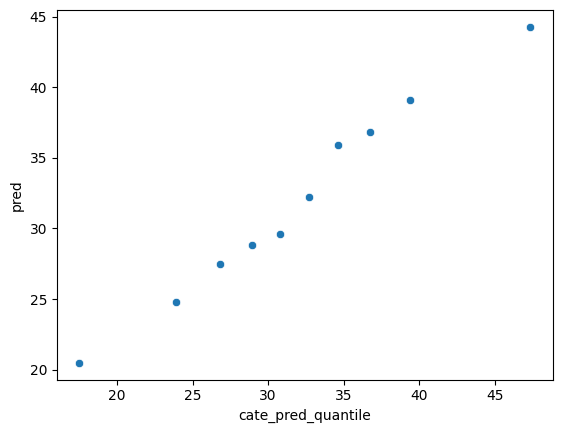

In [12]:
sns.scatterplot(data=effect_by_quantile(test_pred, "cate_pred", y="sales", t="discounts").reset_index().rename(columns={0: "pred"}),
                x="cate_pred_quantile", y="pred")

/var/folders/sh/kl0p__nj01dd11mtnll0179r0000gn/T/ipykernel_24803/3668884922.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean()) * data[y]) / sum( (data[t] - data[t].mean())**2 ))


<Axes: xlabel='ml_pred_quantile', ylabel='pred'>

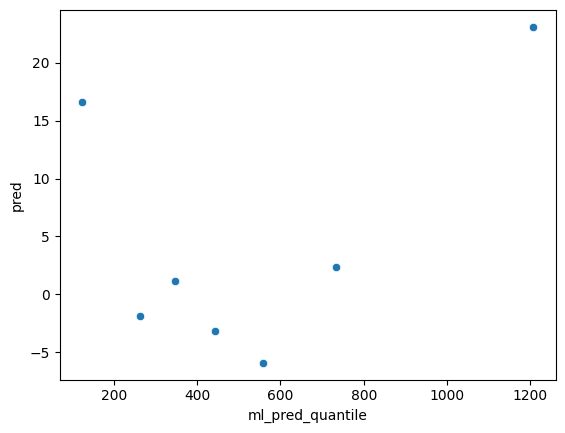

In [13]:
sns.scatterplot(data=effect_by_quantile(test_pred, "ml_pred", y="sales", t="discounts").reset_index().rename(columns={0: "pred"}),
                x="ml_pred_quantile", y="pred")

# Cumulative Effect

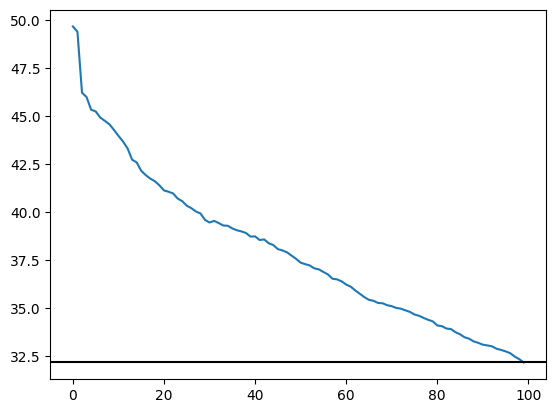

In [14]:
def cumulative_effect_curve(dataset, prediction, y, t, ascending=False, steps=100):
    size = len(dataset)
    ordered_df = (dataset
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size / steps, size, steps).round(0)

    return np.array([effect(ordered_df.query(f"index <= {row}"), t=t, y=y) for row in steps])


sns.lineplot(cumulative_effect_curve(test_pred, "cate_pred", "sales", "discounts")).axhline(y= effect(test, "sales", "discounts") , c="black")

In [15]:
def cumulative_gain_curve(df, prediction, y, t, ascending=False, normalize=False, steps=100):
    effect_fn = effect(t = t, y = y)
    normalizer = effect_fn(df) if normalize else 0

    size = len(df)
    ordered_df = (df
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size / steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index <= {row}")) - normalizer) * (row / size) for row in steps]

    return np.array([0] + effects)


cumulative_gain_curve(test_pred, "cate_pred", "sales", "discounts")

array([ 0.        ,  0.50387597,  0.982917  ,  1.38863289,  1.83046877,
        2.26408709,  2.71880783,  3.13779256,  3.58003148,  4.01798404,
        4.42379877,  4.83861979,  5.23242282,  5.62890903,  5.98551452,
        6.38159081,  6.74402024,  7.13257317,  7.5088165 ,  7.9068624 ,
        8.26968674,  8.63441305,  9.03646968,  9.41649072,  9.76869065,
       10.13172457, 10.48178647, 10.85654343, 11.20031099, 11.57715392,
       11.88179285, 12.22484979, 12.65329367, 13.00147394, 13.35835129,
       13.75177168, 14.08571614, 14.44720258, 14.8206963 , 15.16915263,
       15.48942971, 15.87058782, 16.18483861, 16.5889676 , 16.87711862,
       17.226077  , 17.51523959, 17.85547549, 18.1943502 , 18.48062947,
       18.77790182, 19.05825319, 19.38214231, 19.7240743 , 20.00659491,
       20.35269886, 20.65268403, 20.93862963, 21.18225404, 21.53351325,
       21.82793867, 22.09450014, 22.38142964, 22.62161465, 22.87752468,
       23.11063608, 23.3799479 , 23.70688475, 23.97456335, 24.32

<Axes: >

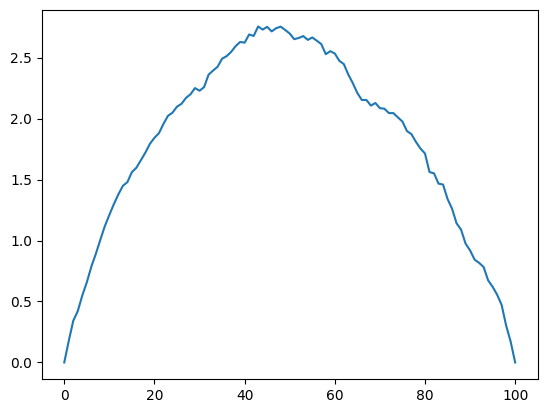

In [71]:
sns.lineplot(cumulative_gain_curve(test_pred, "cate_pred", "sales", "discounts", normalize=True))

In [76]:
np.trapz(cumulative_gain_curve(test_pred, "cate_pred", "sales", "discounts", normalize=True)) #AUC

181.7407448835945

# Target Transformation

In [26]:
from sklearn.metrics import mean_squared_error

X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]

y_res = smf.ols(f"sales ~ {'+'.join(X)}", data=test).fit().resid
t_res = smf.ols(f"discounts ~ {'+'.join(X)}", data=test).fit().resid

tau_hat = y_res / t_res

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    wmse = mean_squared_error(tau_hat, test_pred[m], sample_weight=t_res**2)
    print(f"MSE for {m}:", wmse)

MSE for rand_m_pred: 1115.803515760459
MSE for ml_pred: 576256.7425385381
MSE for cate_pred: 42.904474055502796
